# Fine Tuning For BERT Models with TPU

###Arka uç atanamadı

TPU kullanan arka uçlardan hiçbiri boşta değil. Hızlandırıcısı olmayan bir çalışma zamanı kullanmak ister misiniz?

Yukarıdaki uyarıyı alırsanız. İptal butonuna tıklayın ve 2-3 dakikaya bir aşağıdaki hücreyi tekrar çalıştırın.

In [ ]:
import tensorflow as tf
import os

# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

# TPU çekirdeklerinin hızından faydalanabilmek için öncelikle bu çekirdekleri tahsis ediyor ve strategy değişkenine atıyoruz.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
# BERT transformerslar üzerine kurulu olduğundan BERT modelleri kullanabilmek için transformersları install ediyoruz öncelikle.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 59.2 MB/s eta 0:00:00


## Import Library

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/hepsiburada.zip', encoding="utf-8")

In [ ]:
df.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


In [ ]:
df.Rating.value_counts()

1    229821
0     13676
Name: Rating, dtype: int64

In [ ]:
df.Rating.value_counts(normalize=True)

1    0.943835
0    0.056165
Name: Rating, dtype: float64

In [ ]:
df.Rating = df.Rating.map({1:0, 0:1})

# hedef labelımızı 1 yapıyoruz.

In [ ]:
X = df['Review'].values
y = df['Rating'].values

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

### Tokenization Example For BERT

https://huggingface.co/dbmdz/bert-base-turkish-uncased

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

# Yukarıya linkini bıraktığım huggingface bert türk linkinden tokenizer ve model kurma işlemlemleri için gerekli olan kodları aynen
# alıp burada kullanabiliyoruz. 
# Tokenizer işlemleri için kullanacağımız kodu tokenizer diye bir değişkene atıyoruz.

In [ ]:
text = "Şentepeli Şükrü abi çok güzel bir insan?😊 9901233 #jkl()="
 
tokenizer.tokenize(text)

# textimizi tokenizer.tokenize() fonksiyonunun içine verdiğimizde wordpiece tokenizer işlemini uygular ve bize çıktısını döndürür. 

['sent',
 '##epe',
 '##li',
 'suk',
 '##ru',
 'abi',
 'cok',
 'guzel',
 'bir',
 'insan',
 '?',
 '😊',
 '99',
 '##0',
 '##12',
 '##33',
 '#',
 'j',
 '##k',
 '##l',
 '(',
 ')',
 '=']

In [ ]:
sentence = "Şentepeli Şükrü abi çok güzel bir insan?😊"
tokens = tokenizer.encode(sentence, add_special_tokens=True)
print(tokens)
print(len(tokens))

# tokenizer.encode textimizi DL modellerinde olduğu gibi tokenleri numeric versiona dönüştürür.
# Cümlenin/yorumun başlangı-[CLS] ve bitiş-[SEP] noktalarını gösteren special tokenler her texte ilave edilir.
# Bu şekilde numeric versiona dönüştürülmüş vektöre BERT modellerinde token embeddings vektörü (input_ids) denir.
# Ancak BERT modelleri texti sadece token embeddings vektörü olarak istemez. 
# token embeddings (input_ids), segment embeddings (token_type_ids), position embeddings (attention_mask) vektörlerine dönüştürülmüş 
# şekilde 3 ayrı vektör olarak ister.

# token embedding DL modellerinde olduğu gibi tokenlerin BERT modelinin hafızasında kaçıncı token olduğu bilgisine göre numeric forma dönüştürür.
# segment embedding translation, soru cevap, sentence similarity (cümle benzerliği) gibi tasklerde kullanılır. Örneğin translation taski için modele verilecek textin 
# hangi kısmının türkçe, hangi kısmının ingilizce olduğunu modelin anlayıp bu iki farklı text yapısı arasında tokenlerin birbirleriyle anlamsal ilişkiler kurmasını
# sağlar. Türkçe kısmı 0'lar ile temsil edilirken ingilizce kısmı 1'lerle temsil edilir (yada tam tersi olabilir).
# position embedding tokenlerin textin kaçıncı tokeni olduğu bilgisini modele besler. Bu şekilde model tokenlerin sıralamasına göre anlamasal ilişkileri kurabilir.
# Ancak classificaiton ve sentiment analysis görevlerinde segment embedding kullanılmaz.

# Bunun için aşağıda göreceğimiz encode_plus kodunu kullanacağız. 

[2, 15955, 11679, 2033, 28792, 2239, 8621, 6191, 14533, 1993, 2419, 35, 989, 3]
14


### Fixing token counts of all documents

In [ ]:
# For every sentence...
max_token = []
for sent in X:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_token.append(len(input_ids))

print('Max sentence length: ', max(max_token))

# tokenizer.encode() fonksiyonunu sadece en uzun yorumun kaç tokenden oluştuğu bulmak ve tüm yorumları/textleri kaç
# tokene sabitliyeceğimize karar vermek için kullanacağız.

Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  546


In [ ]:
np.array(max_token).mean()

39.53032686234327

In [ ]:
sum(np.array(max_token) <= 160) / len(max_token)

# tüm yorumları 160 tokene sabitlemeye karar veriyoruz.

0.9852072099450917

### Transformation Vectors to Matrices

In [ ]:
sentence = "Şentepeli Şükrü abi çok güzel bir insan?😊"
tokens = tokenizer.encode_plus(sentence, add_special_tokens=True)
print(tokens)

# tokenizer.encode_plus() fonksiyonu BERT modellerinin istediği gibi texti token embeddings (input_ids), segment embeddings (token_type_ids), 
# position embeddings (attention_mask) vektörlerine dönüştürür.
# tokenizer.encode()'da yaptığımız gibi burda da yine cümlenin/yorumun başlangıç-[CLS] ve bitiş-[SEP] noktalarını gösteren special tokenler her texte ilave edilir.

# ÖNEMLİ NOT: BERT classification ve sentiment analys tasklerinde sadece embeddings (input_ids), position embeddings (attention_mask) kullanılır.

{'input_ids': [2, 15955, 11679, 2033, 28792, 2239, 8621, 6191, 14533, 1993, 2419, 35, 989, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.encode_plus(sentence, max_length=160, truncation=True,
                              padding='max_length', add_special_tokens=True)
tokens

# Yorumları 160 tokene sabitlemeye karar verdiğimizden tokenizer.encode_plus() fonksiyonu içerisine max_length=160, truncation=True, padding='max_length' parametlerini 
# vererek tüm yorumlar 160 token olacak şekilde kırpma (truncation=True) ve dolgulama (padding='max_length') işlemlerini yapıyoruz. Burda dikket etmemiz gereken
# husus padding = True kullanmıyoruz bunun yerine yerine padding='max_length' kullanıyoruz.
# Ayrıca textler [CLS] ve [SEP] special tokenleri ilave edilmiş şekilde 160 tokene sabitlenecektir.

# Gördüğünüz gibi 3 vektörde 160 tokene sabitlendi. Classificaiton problemlerinde segment embeddings (token_type_ids) sadece 0'lardan oluşan bir vektör
# olacağından classification problemlerinde kullanılmadığını unutmuyoruz.

{'input_ids': [2, 15955, 11679, 2033, 28792, 2239, 8621, 6191, 14533, 1993, 2419, 35, 989, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
np.array(tokens['input_ids'])

array([    2, 15955, 11679,  2033, 28792,  2239,  8621,  6191, 14533,
        1993,  2419,    35,   989,     3,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
np.array(tokens['attention_mask'])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
# Elimizde tek bir yorum/text varken BERT modelleri 3 ayrı vektör (classificaiton problemleri için 2 ayrı vektör) olarak textin numeric versiona dönüştürülmesini
# ister. Ancak birden fazla yorum varsa artık olayın boyutu değişir. Ve vektörlerin biraraya gelmesiyle oluşan matrixler isterler.
# Problemimiz classification olduğundan token embeddings (input_ids), position embeddings (attention_mask) vektörlerinden oluşan 2 ayrı matrix elde etmemiz gerekiyor.
# Bunun için öncelikle input_ids ve attention_mask için boş listeler oluşturup for döngüsüyle X'den tüm yorumları sırayla çekip bu yorumlardan elde ettiğimiz input_ids,
# attention_mask vektörlerini boş listeler içine append edip son aşamada bu listeleri array() fonksiyonu ile  (satır sayısı, sabitlediğimiz token sayısı) --> (len(X), 160) 
# boyutunda matrixlere dönüştürüyoruz.

def transformation(X):
  # set array dimensions
  seq_len = 160

  # input_ids'ler için Xids boş listesini, attention_mask'ler için Xmask boş listesini oluşturuyoruz.
  Xids = []
  Xmask = []

    
  for sentence in X: # corpustan tüm yorumları sırayla çekiyoruz.

      tokens = tokenizer.encode_plus(sentence, max_length=seq_len, truncation=True,
                                      padding='max_length', add_special_tokens=True) 
      # çektiğimiz herbir yorumu(sentence) vektörlere dönüştürüyoruz.
      
      # assign tokenized outputs to respective rows in numpy arrays
      Xids.append(tokens['input_ids']) # her bir yoruma karşılık gelen input_ids vektörünü Xids listesine append ediyoruz.
      Xmask.append(tokens['attention_mask']) # her bir yoruma karşılık gelen attention_mask vektörünü Xmask append ediyoruz.

  return np.array(Xids), np.array(Xmask) # Xids ve Xmask listelerini np.array ile (yorum sayısı, 160) boyutlarında matrixlere dönüştürüyoruz.

In [ ]:
Xids_train, Xmask_train = transformation(X_train)

# Train setimiz için 2 ayrı matriximizi düzenliyoruz.

Xids_test, Xmask_test = transformation(X_test)
# Test setimiz için de 2 ayrı matriximizi düzenliyoruz.

In [ ]:
Xids_train

array([[    2,  7147,    21, ...,     0,     0,     0],
       [    2, 21093, 13520, ...,     0,     0,     0],
       [    2,  2156, 12812, ...,     0,     0,     0],
       ...,
       [    2, 11944,  4036, ...,     0,     0,     0],
       [    2,  6191, 30453, ...,     0,     0,     0],
       [    2,  6191, 14533, ...,     0,     0,     0]])

In [ ]:
print("Xids_train.shape  :", Xids_train.shape)
print("Xmask_train.shape :", Xmask_train.shape)
print("Xids_test.shape   :", Xids_test.shape)
print("Xmask_test.shape  :", Xmask_test.shape)

Xids_train.shape  : (219147, 160)
Xmask_train.shape : (219147, 160)
Xids_test.shape   : (24350, 160)
Xmask_test.shape  : (24350, 160)


In [ ]:
y_train

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
labels_train = y_train.reshape(-1,1)
labels_train

# BERT modelleri target'ı da bir matrix olarak ister. Bu sebeple y_train targetımızı (len(y_train), 1) boyutunda bir matrix'e dönüştürüyoruz.

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
labels_test = y_test.reshape(-1,1)
labels_test

# BERT modelleri target'ı da bir matrix olarak ister. Bu sebeple y_train targetımızı (len(y_train), 1) boyutunda bir matrix'e dönüştürüyoruz.

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
from tensorflow.keras.utils import to_categorical

l = np.array([0, 1, 3, 5, 4, 2])
to_categorical(l, 6) 

# Eğer targıtımız binary değilde multi-class olsaydı o zaman target'ı matrix'e dönüştürmek için to_categorical fonksiyonunu kullanacaktık.

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

## Transformation Matrix to Tenserflow Tensor

In [ ]:
import tensorflow as tf

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_train

# Datayı BERT modellerine vermeden önceki son aşama yukarıda elde ettiğimiz matrixleri gruplandırılmış Tensorflow tensörlerine dönüştürmektir.
# Bir tensor, bir veya daha fazla boyutta veri topluluğunu ifade eden bir matematiksel yapıdır. Tek boyutlu tensör vektör olarak, 2 boyutlu tensör matrix olarak, 
# 3 ve daha büyük boyuttaki tensörler ise yüksek boyutlu tensörler olarak ifade edilir.

# Tensorflow  tensörleri GPU/TPU gibi donanımların daha hızlı çalışmasını veya paralel işleme gibi işlemlerin daha effektif yapılmasını sağlar. 
# TensorFlow tensörleri, TensorFlow kütüphanesi tarafından sağlanan otomatik türev alma özelliklerini de kullanabilir. Ancak numpy.array() bu işlemleri sağlayamadığı 
# için Tesorflow kütüphanesi ile Tensörlere dönüştürüyoruz.

# Ayrıca, tf.data.Dataset.from_tensor_slices fonksiyonu, Xids_train, Xmask_train, labels_train tensörlerinin 3'ünü gruplar haline getirir. Model böylece bu 3 tensörün
# aynı veriyi temsil ettiğini anlayacaktır.

# Bu kapsamda, train datası için yukarıda elde ettiğimiz 3 ayrı matrix'mizi de gruplandırılmış Tensorflow tensörlerine dönüştüreceğiz. 

<TensorSliceDataset element_spec=(TensorSpec(shape=(160,), dtype=tf.int64, name=None), TensorSpec(shape=(160,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))
dataset_test

# Train datasına yaptığımız gibi test datası için de 3 ayrı matrix'mizi gruplandırılmış Tensorflow tensörlerine dönüştüreceğiz.

<TensorSliceDataset element_spec=(TensorSpec(shape=(160,), dtype=tf.int64, name=None), TensorSpec(shape=(160,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [ ]:
def map_func(Tensor_Xids, Tensor_Xmask, Tensor_labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': Tensor_Xids, 'attention_mask': Tensor_Xmask}, Tensor_labels
  
# Yukarıda elde ettiğimiz tensörlerden hangisi 'input_ids' hangisi 'attention_mask' ve hangisi labels model bunları bilemez. Bu sebeple
# bu bilgiyi bizim modele sağlamamız gerekiyor. Bunun için yukarıdaki fonksiyonu tanımlıyoruz.
# süslü parantez içerisine 'input_ids' ve  'attention_mask' tanımlamamızı yapıyoruz. Labels'ı süslü parantez dışarısında bırakıyoruz.

In [ ]:
# then we use the dataset map method to apply this transformation
dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func) 

# yukarıda tanımladığımız fonksiyonu map ile tüm train ve test datasına uyguluyoruz.
# dataset_train.map(map_func) ve dataset_test.map(map_func) şeklinde de dönüşümler yapılır. 

In [ ]:
dataset_train

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(160,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(160,), dtype=tf.int64, name=None)}, TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [ ]:
dataset_test

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(160,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(160,), dtype=tf.int64, name=None)}, TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

## Batch Size Train and Validation Dataset

In [ ]:
batch_size = 32

# BERT modeli geliştiren developerlar tarafından batch_size olarak 16 ve 32 sayıları tavsiye edilmiştir.

# batch_size 
# fit into a batch of 32
train_ds = dataset_train.batch(batch_size)
val_ds = dataset_test.batch(batch_size)

# Yukarıda elde ettiğimiz gruplandırılmış tensörleri kaçarlı paketler halinde modele vereceğimizi belirliyoruz. Bu işlemi batch() fonksiyonu ile yapıyoruz.
# 32'li paketler halinde modele verilmesini istiyoruz. hem train hem de test datasına uyguluyoruz.

In [ ]:
train_ds

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 160), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 160), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert

In [ ]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.6 MB/s eta 0:00:00


In [ ]:
print(len(train_ds)*3)
print(int(0.1*len(train_ds)*3))

20547
2054


In [ ]:
from official.nlp import optimization
epochs = 3
#batch_size = 32
steps_per_epoch = len(train_ds)

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5  # 3e-5, 5e-5
optimizer= optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')  

# Num_warmup_steps (ısınma adım sayısı), bir optimizasyon işleminde, modelin eğitim sürecinde kullanılacak olan optimizatörün öğrenme oranının (learning rate) nasıl 
# belirleneceğini belirler. Öğrenme oranı, modelin eğitim sürecinde ne kadar hızlı öğreneceğini ve güncelleyeceğini belirler. Öğrenme oranının çok yüksek olması, modelin
# eğitim sürecinde hızlı öğrenmesine neden olabilir, ancak aynı zamanda modelin overfitting riskini de artırabilir. Öğrenme oranının çok düşük olması ise, modelin eğitim
# sürecinde çok yavaş öğrenmesine neden olabilir.

# Num_warmup_steps, modelin eğitim sürecinde optimizatörün öğrenme oranının, eğitim sürecinin başlangıcında düşük olmasını ve eğitim süreci ilerledikçe yavaş yavaş 
# yükselmesini sağlar. Bu sayede, modelin eğitim sürecinde daha düşük bir oranda hata yapma riski vardır ve modelin eğitim süreci daha düzenli ilerler. Bu da modelin 
# daha iyi bir performans göstermesini sağlar. 


# steps_per_epoch bir epochun kaç adımda tamamlanacağını gösterir. len(train_ds) = 6849 --> len(train_ds) sayısı train_datasının kaç tane 32'li paketlerden/adımlardan 
# oluştuğunu gösterir.
# ÖNEMLİ NOT: train datalarındaki son paketler/adımlar  32'den daha az gözlemden oluşabilir. Mesela bu train_ds datamızın son paketinde/adımında 11 gözlem vardır. 
# Ancak, 32'den daha az gözlem olsa da biz yinede bunları bir paket/adım olarak sayıyoruz.

# num_train_steps, eğitimin toplamda kaç adımda tamamlanacağını gösterir. Eğitim 3 epochda tamamlanacağı için steps_per_epoch(len(train_ds)) * epochs --> 6849 * 3 = 20547
# num_warmup_steps, num_train_steps'in %10'u (20547x0.1 = 2054) olacak şekilde alınması tavsiye edilmiştir. Ancak bu oranı biraz daha azaltıp/artırarak skorlarınızı 
# gözlemleyebilirsiniz. num_warmup_steps'in 2054 olması şu anlama geliyor. Model eğitime başladığında optimization.create_optimizer fonksiyonunun içine verdiğimiz 2e-5 
# öğrenme oranı ile direk eğitime başlamaz. 
# Eğitimin ilk 2054 adımında öğrenme oranı 0 ile 2e-5 arasında olacak şekilde kademeli olarak yavaş yavaş artırılır ve 2054'üncü adımdan sonra eğitim 2e-5 oranı ile devam eder.
# Bu sayede modelin eğitim sürecinde daha düşük bir oranda hata yapma riski vardır ve modelin eğitim süreci daha düzenli ilerler. Bu da modelin daha iyi bir performans 
# göstermesini sağlar. 

# Dikkat ederseniz burda AdamW (Adam with Weight Decay) optimizatörünü kullandık. AdamW, Adam optimizatörüne ek olarak, ağırlık azaltma (weight decay) özelliği de içerir. 
# Ağırlık azaltma, modelin ağırlıklarının eğitim sürecinde daha az değişmesini sağlar ve bu sayede overfitting riskini azaltır.

# BERT modellerinde developerların tavsiye ettiği öğrenme oranları 2e-5, 3e-5 ve 5e-5'dir.
# BERT modellerinde developerların tavsiye ettiği epoch sayısı 2 veya 3'dür. Daha büyük sayılar overfitinge sebep olur. 
# Deneme yanılma ile hangi öğrenme oranlarının ve epoch sayılarının daha iyi sonuçlar verdiğini gözlemlememiz gerekiyor.

## Creating Model

In [ ]:
def create_model():
    from transformers import TFAutoModel
    # BERTTürk modeli sadece pytorch tensörleri üzerinden eğitildiğinden modelin Tensorflow kütüphanesi ile çalışabilmesi için AutoModel yerine TFAutoModel yazıyoruz.
    from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization
    from tensorflow.keras import Model

    model = TFAutoModel.from_pretrained("dbmdz/bert-base-turkish-uncased") 
    # Notebookun yeralan huggingface bert türk linkinden model kurma işlemlemleri için gerekli olan kodları aynen alıyoruz.
    # Tokenization işlemleri "dbmdz/bert-base-turkish-uncased" ile yapıldığından eğitimide "dbmdz/bert-base-turkish-uncased" ile yapmamız gerekiyor. 
    # "dbmdz/bert-base-turkish-cased" ile eğitim yapılırsa sonuçlarımız kötü çıkacaktır.

    input_ids = Input(shape=(160,), name='input_ids', dtype='int32')
    attention_mask = Input(shape=(160,), name='attention_mask', dtype='int32')
    # inputlarımız token embeddings (input_ids) ve position embeddings (attention_mask)'den oluştuğundan herbiri için bir input layer oluşturuyoruz.
    # Her bir gözlem için input layerlarımızın boyutlarını (shape= (160,)) veriyoruz.
    # modelin bu layerları birbirinden ayırt edebilmesi için name olarak map_func fonksiyonu içinde belirlediğimiz isimleri kullanıyoruz. Farklı isimler kullanılırsa model 
    # hata döndürür.
    # BERT modelleri dtype= "int32" olarak çalışır. Bu sebeple dtype="int32" olarak belirtiyoruz.

    embeddings = model.bert(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"] #[1]
    # embeddings layer, BERT model üzerinde daha önce eğitilip hafızasında tutulan word embeddingleri çektiğimiz katmandır.
    # Çekilen Word embeddingler birleştirilerek sentence embeddinglere dönüştürülür. 
    # Elde ettiğimiz sentence embeddinglerin olumlu mu olumsuz mu olduğuna dair eğitimimizi Dense layer üzerinde yapacağız.

    x = Dense(160, activation='relu')(embeddings)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x) #0.1 oranı developerlar tarafından tavsiye edilen orandır.
    y = Dense(1, activation='sigmoid', name='outputs')(x) # outputumuz döndürüyor.

    # Dikkat ettiyseniz burda Sequential API yerine Functional API kullanıyoruz. 
    # Functional API'de bir önceki layerdaki bilgileri bir sonraki layera aktarma işlemini aktarma yapacağımız layerdan sonra bir tuple açıp içerisine bir önceki layerın ismini 
    # yazarak yapıyoruz.
    # Embeddings layerdan elde ettiğimiz sentence embeddingsleri Dense layer'a göndermek için Dense() layerdan sonra bir tuple açıp içerisine bir önceki layerın ismini yazıyoruz
    # Aynen burda olduğu gibi "Dense(160, activation='relu')(embeddings)". Bu sayede embeddings layerdaki bilgiler Dense layera aktarılmış oldu.
    # Hatırlarsanız bu işlem Sequential API'de model.add(embeddings) olarak yapılıyordu.

    return Model(inputs=[input_ids, attention_mask], outputs=y)
    # son aşamada elde ettiğimiz input ve outputlar Model fonksiyonu içine tanımlanır.

# modeli bir fonksiyon içinde kurma sebebimiz aşağıdaki strategy.scope() kapsamında yapacağımız işlemlerin daha sade görünmesi için yoksa burdaki tüm kodları strategy.scope() 
# altında yazmamız gerekecekti.

In [ ]:
# strategy değişkenine atanan 8 TPU çekirdeğinin hızından faydalanarak yapmak istediğimiz tüm işlemleri with strategy.scope() kod bloğunun 
# altında tanımlıyoruz.

with strategy.scope():

  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.losses import BinaryCrossentropy
  from tensorflow.keras.metrics import Recall
  
  optimizer = optimizer
  #optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5) ==> yukarıda tanımladığımız optimizer'ı kullanmasaydık bu şekilde de optimizer'ı tanımlayabilirdik. 
  # Ama çok rahat overfiting olma riski vardır
  loss = BinaryCrossentropy()
  recall = Recall()
  model3 = create_model()
  model3.compile(optimizer=optimizer, loss=loss, metrics=[recall])

  # Aşağıda çıkan uyarı önemli değildir. Classification tasklerinde modelin eğitim aşamasında Next Sentence Prediction(NSP) katmanını kullanmayacağı
  # bilgisi veriliyor.

Some layers from the model checkpoint at dbmdz/bert-base-turkish-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#pd.Series(y).value_counts(normalize=True)

In [ ]:
#weights = {0:0.05, 1:0.95}

In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 160)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  110617344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 160,                                           

In [ ]:
model3.fit(train_ds, validation_data= val_ds, epochs=epochs)

# Notebook başında hedef labelımızı 1 yapmamızın sebebi modelin döndürdüğü recall ve val_recall metricleri 1 classına ait olan değerlerdir.
# Eğitim esnasında recall ve val_recall metriclerini takip edebilmek maksadıyle hedef labelımızı 1 olarak düzenledik.
# Loss değeri modelin yaptıkları tahminleri ne kadar yüksek olasılıklarla yaptığını gösterir. Model tüm tahminlerini 1.0 olasılıkla yapmışsa loss değeri 0 olur.
# loss = 1/n x (log(olasılık_1) + log(olasılık_2) + log(olasılık_3)+......+ log(olasılık_n))
# loss ve val_loss değeri 0 ve 1 classlarının ortak skorunu döndürür. O yüzden çok dengesiz datasetlerinde çoğunluk sınıfın loss değeri daha ağırlıklı olacağından
# loss ve val_loss değerlerine bakılarak overfiting kararı verilmez. Ancak class_weight yapılırsa loss değerleri dikkate alınabilir.
# recall ve precision metriclerine göre overfiting kararı verilir.

Epoch 1/3
6849/6849 [==============================] - 792s 102ms/step - loss: 0.3973 - recall: 0.6873 - val_loss: 0.1951 - val_recall: 0.7142
Epoch 2/3
6849/6849 [==============================] - 642s 94ms/step - loss: 0.1109 - recall: 0.7020 - val_loss: 0.1619 - val_recall: 0.7668
Epoch 3/3
6849/6849 [==============================] - 643s 94ms/step - loss: 0.0745 - recall: 0.7880 - val_loss: 0.2264 - val_recall: 0.8048


In [ ]:
#history = model3.fit(
   # train_ds2, validation_data= val_ds, class_weight= {0:1, 1:4},
   # epochs=1) #epoch= 2 or 3

## Model evaluation

In [ ]:
model_loss = pd.DataFrame(model3.history.history)
model_loss.head()

,loss,recall,val_loss,val_recall
0,0.397260,0.687277,0.195114,0.714181
1,0.110898,0.701982,0.161918,0.766813
2,0.074458,0.788024,0.226395,0.804825


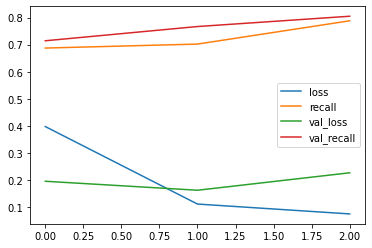

In [ ]:
model_loss.plot()

# loss ve val_loss değeri 0 ve 1 classlarının ortak skorunu döndürür. O yüzden çok dengesiz datasetlerinde çoğunluk sınıfın loss değeri daha ağırlıklı olacağından
# ağırlıklandırma yapmadan loss ve val_loss değerlerine bakılarak overfiting kararı verilmez.
# recall ve precision metriclerine göre overfiting kararı verilir.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model3.predict(val_ds) >= 0.5


print(classification_report(y_test, y_pred))

761/761 [==============================] - 30s 33ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     22982
           1       0.79      0.80      0.80      1368

    accuracy                           0.98     24350
   macro avg       0.89      0.90      0.89     24350
weighted avg       0.98      0.98      0.98     24350



In [ ]:
y_train_pred = model3.predict(train_ds) >= 0.5


print(classification_report(y_train, y_train_pred)) 

# train datasının scorları için karılmamış train_ds datasını kullanıyoruz.

6849/6849 [==============================] - 188s 27ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    206839
           1       0.87      0.87      0.87     12308

    accuracy                           0.99    219147
   macro avg       0.93      0.93      0.93    219147
weighted avg       0.99      0.99      0.99    219147



761/761 [==============================] - 21s 27ms/step


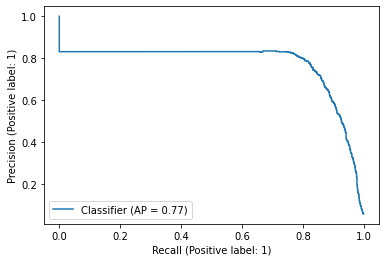

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_pred_proba = model3.predict(val_ds)

PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.show();

In [ ]:
model3.save_weights("/content/drive/MyDrive/sentiment_model.h5")

# Eğitim sonrası elde ettiğimiz model ağırlıklarını/katsayılarını save_weights fonksiyonu ile drive yolunu/ismini vererek drive kaydediyoruz.

In [ ]:
with strategy.scope():

  model4 = create_model()
  model4.load_weights("/content/drive/MyDrive/sentiment_model.h5")

# Drive kaydettiğimiz model ağırlıklarını/katsayılarını yüklemeden önce yukarıda create_model fonksiyonu altına tanımladığımız BERT modeli kuruyoruz.
# Kurduğumuz bu modeli model4 değişkenine atıp eğitilmemiş olan bu modele ağırlık/katsayıları yüklüyoruz.

Some layers from the model checkpoint at dbmdz/bert-base-turkish-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Predictions

In [ ]:
# train ve test datasının gruplandırılmış tenserflow tensörlerine dönüştürülme işlemlerinin aynısını sırasıyla predict edeceğimiz observationlara(obs) aynen uyguluyoruz.

def prep_data(text):
  import tensorflow as tf
  
  # 1. Predict edeceğimiz yeni gözlemleri öncelikle token embeddings (input_ids) ve position embeddings (attention_mask) matrixlerine dönüştürüyoruz.
  #    Bu fonksiyonu kullanabilmek için öncelikle transformation funksiyonunu çalıştırmanız gerektiğini unutmayın.
  Xids_obs, Xmask_obs = transformation(text) 
  
  # 2. Xids_obs, Xmask_obs matrixlerimizi gruplandırılmış tenserflow tensörlerine dönüştürüyoruz.
  dataset_obs = tf.data.Dataset.from_tensor_slices((Xids_obs, Xmask_obs))
  
  # 3. Dönüştürdüğümüz gruplandırılmış tensorflow tensörlerini modelin tanıyabilmesi için "input_ids" ve "attention_mask" olarak isimlendiriyoruz.
  def map_func(Tensor_Xids, Tensor_Xmask):
       return {'input_ids': Tensor_Xids, 'attention_mask': Tensor_Xmask}
  
  dataset_obs = dataset_obs.map(map_func)

  # 4. Son aşama olarak gruplandırılmış tensorflow tensörlerimizi train datasında olduğu gibi 32'li paketler haline getiriyoruz. Yoksa shape uyumsuzluk hatası alırız. 
  batch_size = 32 # eğitim datasına uygulanan batch_size'ı uyguluyoruz.
  obs_ds = dataset_obs.batch(batch_size)

  return obs_ds 

In [ ]:
review1 = "çok beğendim herkese tavsiye ederim"
review2 = "süper ürün aynı gün elime geçti"
review3 = "büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım"
review4 = "kelimelerle tarif edilemez"
review5 = "tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten"
review6 = "hiç resimde gösterildiği gibi değil"
review7 = "kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım teşekkürler"
review8 = "hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum"
review9 = "tam bir fiyat performans ürünü"
review10 = "beklediğim gibi çıkmadı"
review11 = "on numara beş yıldız"
review12 = "bu kargoyu biran önce bırakın. yoksa üründe sıkıntı yok"
review13 = "televizyonun görüntü kalitesi çok kötü, dün akşam evde arkadaşlarla toplandık. yedik, içtik, sohbet ettik. Sonra televizyonda Türkiye - İngiltere maçını seyrettik. "
review14 = '1 gün gibi kısa bir sürede elime geçti. Ve bu fıyata süper bir ürün tavsiye ederim. Lakin eli büyük olan kişiler daha büyük modelini tercih edebilirler ortaboy ürün. Teşekkürler '
review15 = "alınca anlarsın hanyayı konyayı"
review16 = "çöpe atacak paran varsa al"
review17=  "Telefon çok da kötü değil"
review18 = "al da gününü gör"
review19 = "Ürün harika ama satıcı ve kargo berbat"
review20 = "kargo süper ama ürün berbat"
review21 = "Aldigim TV cok kaliteli diye dusunmustum, sonradan cok da iyi bir TV olmadigini dusundum, ama neyse yine de memnunum."
review22 = "😊"
review23 = ":)"
review24 = "I ❤️ you"
review25 = 'telefon kesinlikle bu parayı hak etmiyor. yeni hiç bir özelliği yok. ancak küçük ekran sevenler için iyi bir telefon'
review26 = 'müthiş bir telefon ama bu parayı hak etmiyor'
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10, review11, review12, review13, review14, review15, review16, review17, 
           review18, review19, review20, review21, review22, review23, review24, review25, review26] 

# oluşturduğumuz tüm yorumları bir array veya list içerisine alıyoruz.

In [ ]:
obs_ds = prep_data(reviews)

# Datamızı gruplandırılmış tensorflow tensörlerine dönüştürüyoruz.

In [ ]:
probs = model4.predict(obs_ds)
probs

# predictionlarımızı alıyoruz.

1/1 [==============================] - 11s 11s/step


array([[0.00191668],
       [0.00244144],
       [1.        ],
       [0.00394079],
       [1.        ],
       [1.        ],
       [0.00254443],
       [1.        ],
       [0.00191084],
       [1.        ],
       [0.00194392],
       [0.0060094 ],
       [1.        ],
       [0.00588924],
       [0.01312417],
       [0.99999964],
       [1.        ],
       [0.00364152],
       [0.00501165],
       [1.        ],
       [0.00871927],
       [0.00384054],
       [0.00215083],
       [0.0033173 ],
       [1.        ],
       [0.3494659 ]], dtype=float32)

In [ ]:
probs = [i[0] for i in probs]
probs

[0.0019166768,
 0.002441436,
 1.0,
 0.003940791,
 1.0,
 1.0,
 0.0025444329,
 1.0,
 0.0019108355,
 1.0,
 0.0019439161,
 0.0060094,
 1.0,
 0.005889237,
 0.013124168,
 0.99999964,
 1.0,
 0.003641516,
 0.005011648,
 1.0,
 0.008719265,
 0.0038405359,
 0.0021508336,
 0.0033172965,
 1.0,
 0.3494659]

In [ ]:
classes  = (np.array(probs) >= 0.5).astype("int")
classes

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0])

In [ ]:
my_dict = {"Review":reviews, "prob":probs, "classes":classes}

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(my_dict)

,Review,prob,classes
0,çok beğendim herkese tavsiye ederim,0.001917,0
1,süper ürün aynı gün elime geçti,0.002441,0
2,büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım,1.000000,1
3,kelimelerle tarif edilemez,0.003941,0
4,tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten,1.000000,1
5,hiç resimde gösterildiği gibi değil,1.000000,1
6,kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım teşekkürler,0.002544,0
7,hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum,1.000000,1
8,tam bir fiyat performans ürünü,0.001911,0
9,beklediğim gibi çıkmadı,1.000000,1


In [ ]:
count=0
for i in X_train:
  if "gününü gör" in i.lower():
    count+=1
print(count)

0


In [ ]:
count=0
for i in X_train:
  if "hanyayı konyayı" in i.lower():
    count+=1
print(count)

0


In [ ]:
count=0
for i, j in enumerate(X):
  if "çöpe atacak paran" in j.lower() and y[i]==1:
    count+=1
    print(i)
print(count)

158068
218693
2


In [ ]:
X[158068]

'beş para etmez çöpe atacak paranız varsa alın'